In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from netCDF4 import Dataset
import utils as utl

In [2]:
Nh = 96
Nt = 37
sspacing = 3
tspacing = 4

HTLS_sknots = np.arange(0,Nh,sspacing)
HTHS_sknots = np.arange(0,Nh,1)
LTHS_tknots = np.arange(0,Nh,tspacing)
Nl = len(HTLS_sknots)
Ns = len(LTHS_tknots)

Dh = Nh*Nh
Dl = Nl*Nl

N = Nt*Ns

[]

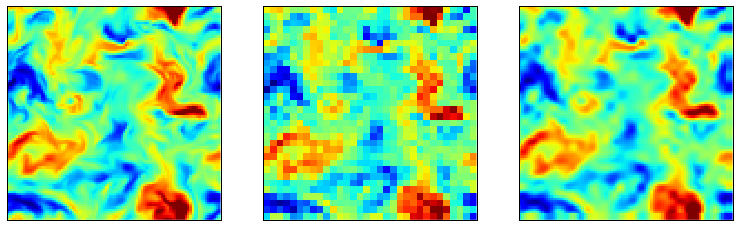

In [3]:
ncfile1 = Dataset('/data/ISOTROPIC/data/data_downsampled4.nc','r')
x_HR_ref = np.array(ncfile1.variables['velocity_x'][0,0:Nh,0:Nh,0])
ncfile1.close()
x_LR = x_HR_ref[0:-1:sspacing,0:-1:sspacing]
x_interp = utl.interp2(HTLS_sknots, HTLS_sknots, x_LR, HTHS_sknots, HTHS_sknots)

fig = plt.figure(figsize=(13, 5))

ax = plt.subplot(1,3, 1)
cax = plt.imshow(x_HR_ref, interpolation='none',clim=[-3,3],cmap='jet')
ax.set_xticks(())
ax.set_yticks(())
    
ax = plt.subplot(1,3, 2)
cax = plt.imshow(x_LR, interpolation='none',clim=[-3,3],cmap='jet')
ax.set_xticks(())
ax.set_yticks(())

ax = plt.subplot(1,3, 3)
cax = plt.imshow(x_interp, interpolation='none',clim=[-3,3],cmap='jet')
ax.set_xticks(())
ax.set_yticks(())

# fig.colorbar(cax, ticks=[-3, -2, -1, 0, 1, 2, 3])

In [4]:
Xh_tr = np.zeros((N, Dh))
Xl_tr = np.zeros((N, Dl))
ncfile1 = Dataset('/data/ISOTROPIC/data/data_downsampled4.nc','r')
for t in range(Nt):
    count = 0
    for i in LTHS_tknots:
        xh = np.array(ncfile1.variables['velocity_x'][t,0:Nh,0:Nh,i])
        xl = xh[0:-1:sspacing,0:-1:sspacing] # xh[np.meshgrid(HTLS_sknots,HTLS_sknots)]
        Xh_tr[t*Ns + count,:] = np.reshape(xh,(1, Dh))
        Xl_tr[t*Ns + count,:] = np.reshape(xl,(1, Dl))
        count = count + 1
ncfile1.close()

In [5]:
# normalized: centered, variance 1
mea_l = np.zeros(Dl)
sig_l = np.zeros(Dl)
for k in range(Dl):
    mea_l[k] = np.mean(Xl_tr[:,k])
    sig_l[k] = np.std(Xl_tr[:,k])
    Xl_tr[:,k] = (Xl_tr[:,k]-mea_l[k])/sig_l[k] 
    
mea_h = np.zeros(Dh)
sig_h = np.zeros(Dh)
for k in range(Dh):
    mea_h[k] = np.mean(Xh_tr[:,k])
    sig_h[k] = np.std(Xh_tr[:,k])
    Xh_tr[:,k] = (Xh_tr[:,k]-mea_h[k])/sig_h[k]     

### Coefficients as functions of lambda

In [6]:
from sklearn import linear_model
n_alphas = 20
alphas = np.append([],np.logspace(-3, 5, n_alphas))

clf = linear_model.Ridge( fit_intercept=False, normalize=False)
coefs_RR = []
for a in alphas:
    clf.set_params(alpha=a)
    clf.fit(Xl_tr, Xh_tr)
    coefs_RR.append(clf.coef_)  

/home/nguyen/anaconda/lib/python2.7/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


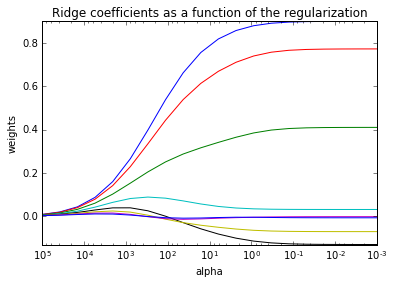

In [7]:
coefs_part = [coefs_RR[i][0:8,0] for i in range (n_alphas)]
ax = plt.gca()
ax.set_color_cycle(['b', 'r', 'g', 'c', 'k', 'y', 'm', 'b'])

ax.plot(alphas, coefs_part)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

### Using RidgeCV to get a rough idea of optimal lambda

In [8]:
from sklearn.linear_model import RidgeCV

n_alphas = 10
alphas = np.linspace(1e-10, 500, n_alphas)

ridge = RidgeCV(alphas = alphas, cv = 6, fit_intercept=False, normalize=False)
ridge.fit(Xl_tr, Xh_tr)

RidgeCV(alphas=array([  1.00000e-10,   5.55556e+01,   1.11111e+02,   1.66667e+02,
         2.22222e+02,   2.77778e+02,   3.33333e+02,   3.88889e+02,
         4.44444e+02,   5.00000e+02]),
    cv=6, fit_intercept=False, gcv_mode=None, normalize=False,
    scoring=None, store_cv_values=False)

In [9]:
print 'Optimal set of coefficients:', ridge.coef_
print 'Optimal regularization parameter:', ridge.alpha_
print np.shape(ridge.coef_)

Optimal set of coefficients: [[ 0.63155619  0.0741841  -0.01463561 ..., -0.00248377  0.00600521
   0.02026639]
 [ 0.51484966  0.25651381 -0.025592   ...,  0.00424688  0.00486014
  -0.00547883]
 [ 0.27818967  0.48911077 -0.0168206  ...,  0.00393079  0.000746
  -0.01039044]
 ..., 
 [ 0.07913634  0.00476832 -0.01528806 ..., -0.02092857  0.0665166
   0.2309682 ]
 [ 0.2281361  -0.001189   -0.00954213 ..., -0.02546336  0.0083498
   0.20816361]
 [ 0.40450636 -0.00521915 -0.01565749 ..., -0.00375429 -0.00843874
   0.12453829]]
Optimal regularization parameter: 55.5555555556
(9216, 1024)


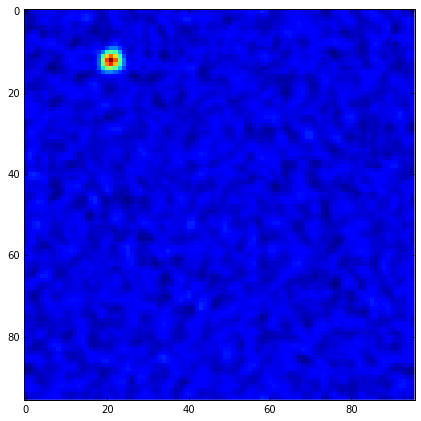

In [10]:
fig = plt.figure(figsize=(8, 7))
plt.imshow(np.reshape(ridge.coef_[:,135],(96,96)),interpolation='none')

### Cross-Validation curve

In [11]:
from sklearn.linear_model import Ridge
from sklearn.learning_curve import validation_curve

param_range= np.append(0, np.logspace(0, 6, 14))
train_scores, test_scores = validation_curve(Ridge(),Xl_tr, Xh_tr, param_name="alpha", param_range=param_range, 
                                             scoring = "mean_squared_error", cv=10)

# API always tries to maximize a loss function, so MSE is actually in the flipped sign
train_scores_mean = np.mean(-train_scores, axis=1)
train_scores_std = np.std(-train_scores, axis=1)
test_scores_mean = np.mean(-test_scores, axis=1)
test_scores_std = np.std(-test_scores, axis=1)

/home/nguyen/anaconda/lib/python2.7/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


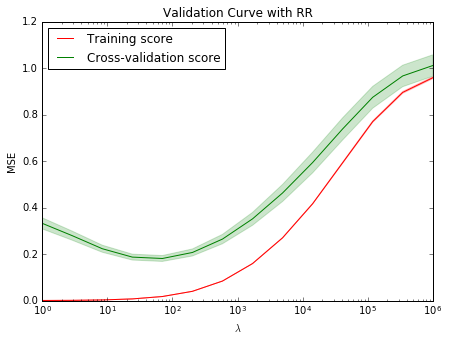

In [12]:
plt.figure(figsize=(7, 5))
plt.title("Validation Curve with RR")
plt.xlabel("$\lambda$")
plt.ylabel("MSE")
#plt.ylim(0, 1.1)
plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std, 
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score", color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std, 
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

In [13]:
print np.shape(test_scores)

(15, 10)
